# Cross validation

Esta es una forma de comparar múltiples modelos de Machine Learning y de darse una idea de qué tan bien funcionarán en la práctica.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import svm

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold
)

## El conjunto de datos

Datos para la predicción de derrames cerebrales.

- Género, estatus marital, fuma, edad, etc.

- Agregar columna del doctor que etiquetó cada registro para agrupar los datos.

In [2]:
def get_prep_data():
    data = pd.read_csv(
        "data/healthcare-dataset-stroke-data.csv"
    ).fillna(0)
    data["ever_married"] = (
        data["ever_married"].replace("Yes", True).replace("No", False)
    )
    data["gender"] = data["gender"].astype("category")
    data["smoking_status"] = data["smoking_status"].astype("category")
    data["Residence_type"] = data["Residence_type"].astype("category")
    data["work_type"] = data["work_type"].astype("category")
    data["doctor"] = np.random.randint(0, 8, size=len(data))
    holdout_ids = data.sample(n=500, random_state=529).index

    train = (
        data.loc[~data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )
    holdout = (
        data.loc[data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )

    return train, holdout


train, holdout = get_prep_data()

C:\Users\jorge\AppData\Local\Temp\ipykernel_22196\242815256.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["ever_married"].replace("Yes", True).replace("No", False)


In [3]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,61171,Female,31.0,0,0,False,Private,Rural,59.63,19.9,never smoked,0,0
1,53660,Male,57.0,0,0,True,Private,Urban,108.53,19.4,smokes,0,0
2,49976,Female,54.0,0,1,True,Private,Urban,140.28,37.1,formerly smoked,0,0
3,55607,Male,38.0,0,0,True,Private,Urban,101.43,27.0,formerly smoked,0,0
4,36331,Male,18.0,0,0,False,Private,Rural,70.34,24.2,Unknown,0,0


In [4]:
def get_X_y(train):
    FEATURES = [
        "age",
        "hypertension",
        "heart_disease",
        "avg_glucose_level",
        "bmi",
    ]

    GROUPS = "doctor"

    TARGET = "stroke"

    X = train[FEATURES]
    y = train[TARGET]
    groups = train[GROUPS]
    return X, y, groups

## Tipos de Cross Validation

In [5]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
        [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )


def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )

    # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()
    
def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_

### Train - Validation split

In [6]:
X, y, groups = get_X_y(train)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
clf = svm.SVC(kernel='linear', C=1, random_state=42, probability=True)
clf.fit(X_train, y_train)
pred = clf.predict(X_val)
pred_prob = clf.predict_proba(X_val)[:,1]
acc_score = accuracy_score(y_val, pred)
auc_score = roc_auc_score(y_val, pred_prob)

print(f"Acc: {acc_score:.4f}  |  AUC: {auc_score:.4f}")

Acc: 0.9675  |  AUC: 0.7395


### KFold

Separa el conjunto de datos en $k$ partes iguales consecutivas. Se entrena y valida el modelo $k$ veces utilizando como conjunto de validación cada parte de las $k$ divisiones, una cada vez. 

c:\Users\jorge\miniconda3\envs\code\Lib\site-packages\sklearn\model_selection\_split.py:91: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


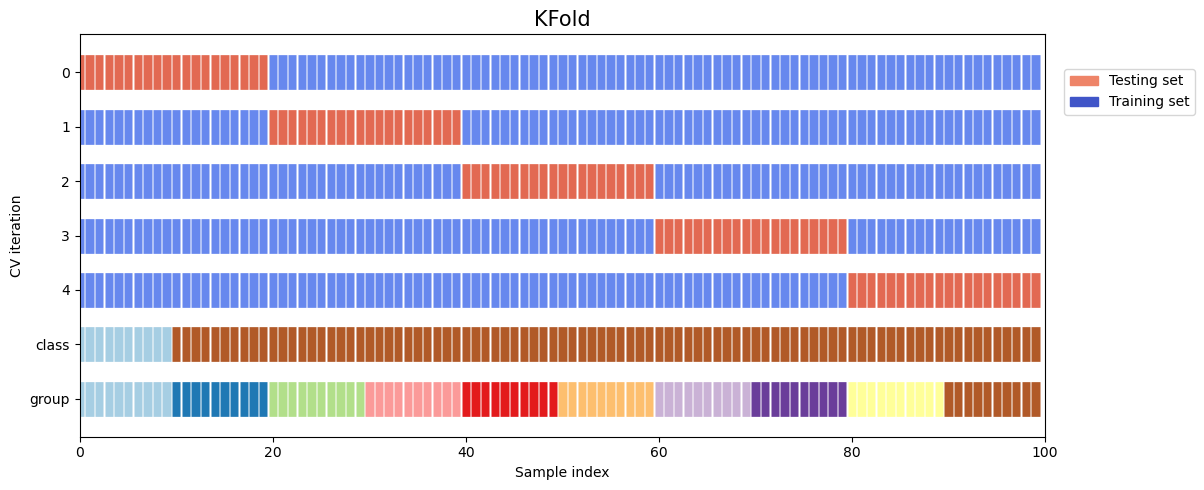

In [7]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

### StratifiedKFold

El mismo proceso que `KFold` pero se preserva el porcentaje de muestras por clase, asegurando que las proporciones de estas en cada validación sea igual a la del conjunto de datos de entrenamiento.

c:\Users\jorge\miniconda3\envs\code\Lib\site-packages\sklearn\model_selection\_split.py:848: UserWarning: The groups parameter is ignored by StratifiedKFold
  warnings.warn(


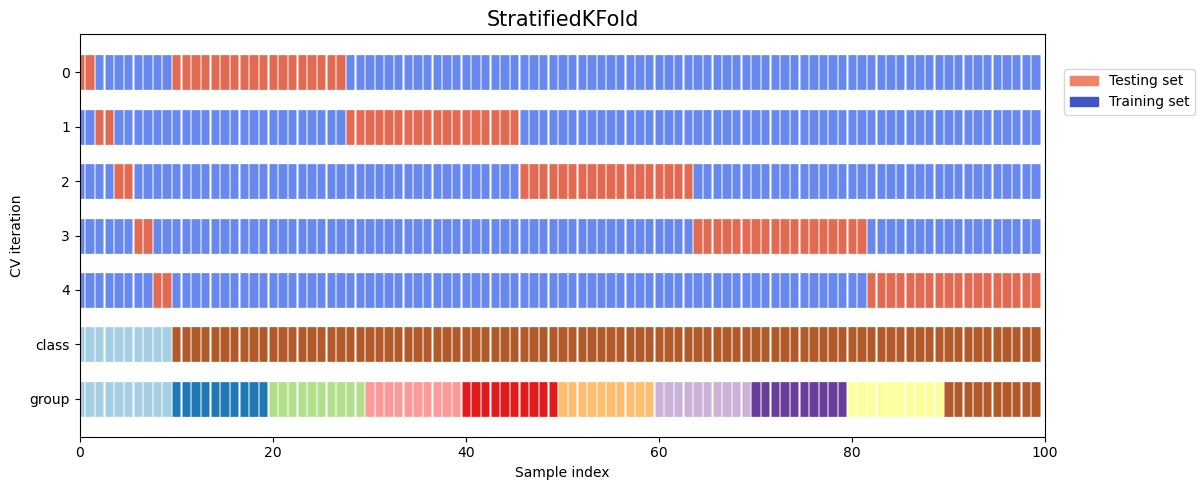

In [8]:
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

### GroupKFold

Las $k$ divisiones son aproximadamente "balanceadas" en el sentido de que el número de grupos distintos en cada partición es el mismo.

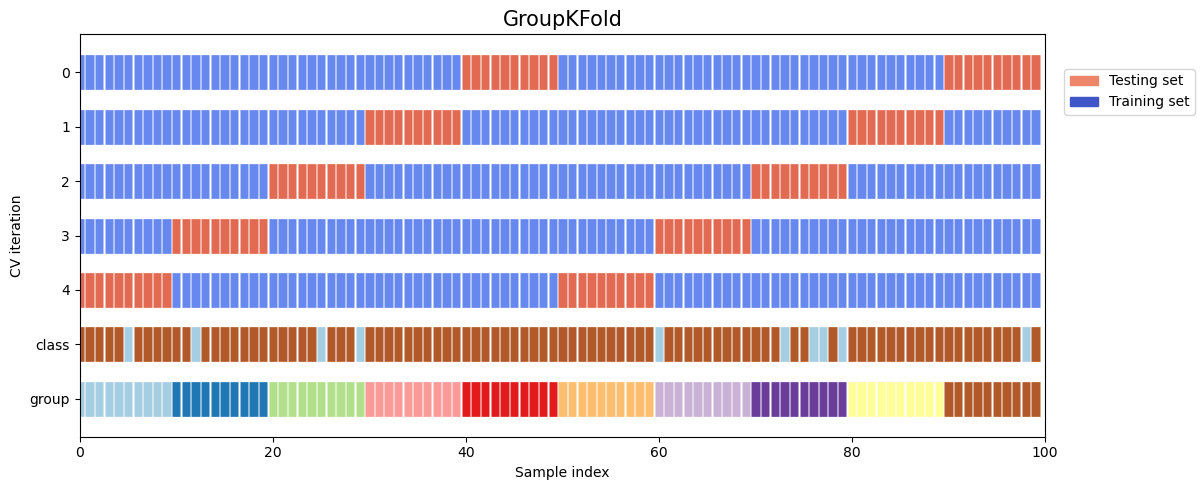

In [9]:
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(GroupKFold, X_, y_, groups_)

### StratifiedGroupKFold

La diferencia entre `GroupKFold` y `StratifiedGroupKFold` es que el primero intenta crear particiones balanceadas tales que el número de grupos distintos en cada partición sea aproximadamente el mismo, mientras que el segundo intenta crear particiones que preserven las proporciones de clases en el número de registros lo más posible dada la restricción de no repetir grupos entre las $k$ particiones.

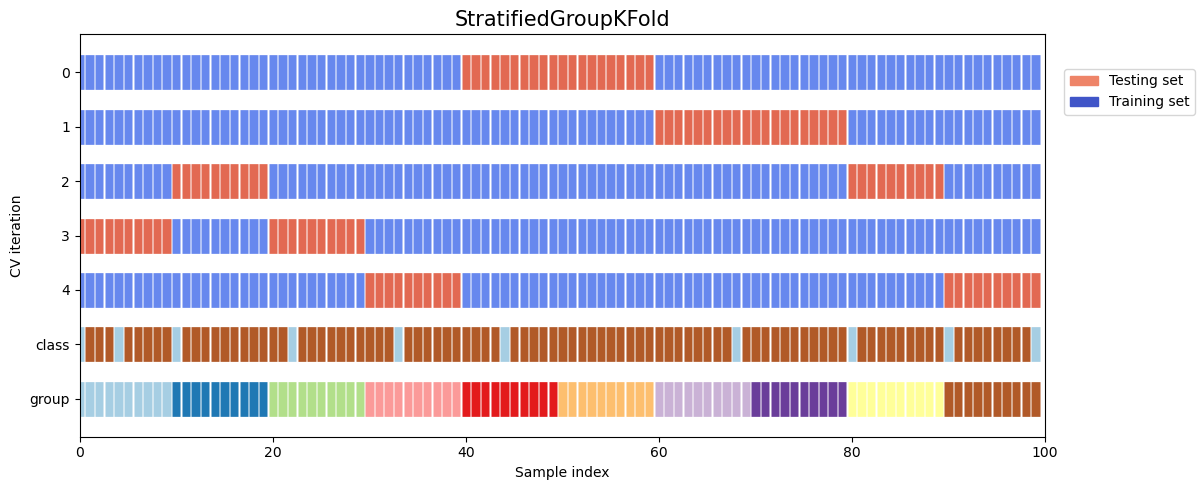

In [10]:
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

### Time Series Split

c:\Users\jorge\miniconda3\envs\code\Lib\site-packages\sklearn\model_selection\_split.py:1213: UserWarning: The groups parameter is ignored by TimeSeriesSplit
  warnings.warn(


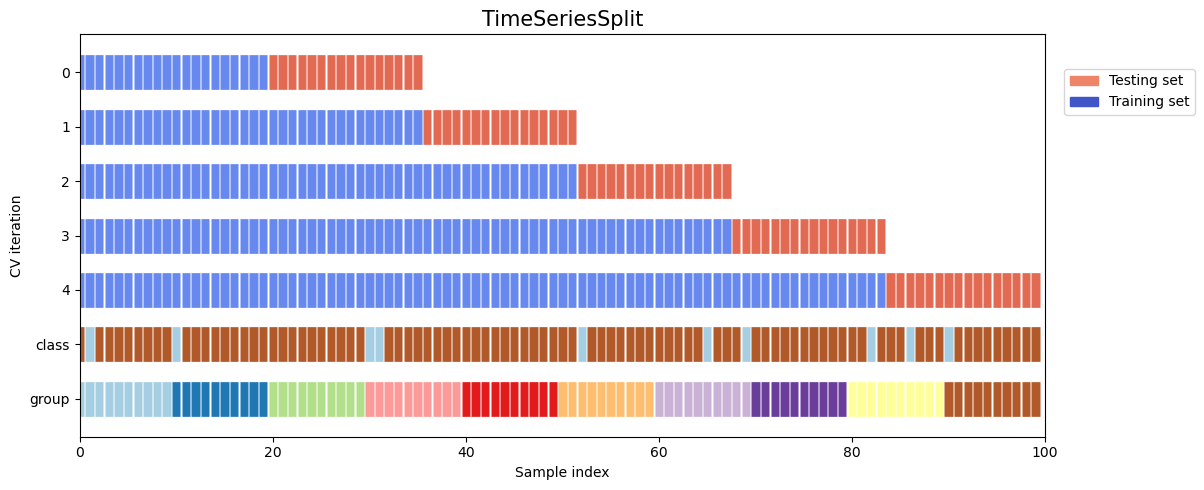

In [11]:
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)

## Aplicación de Cross Validation con un modelo de clasificación

Como el conjunto de datos:

- Tiene **imbalance de clases**

- Se puede agrupar por **doctor**

- Está **ordenado**


Se usará `StratifiedGroupKFold` y se activará la opción **shuffle**

In [12]:
sgkf = StratifiedGroupKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

X, y, groups = get_X_y(train)

fold = 0
aucs = []

for train_idx, val_idx in sgkf.split(X, y, groups):
    X_train = X.loc[train_idx]
    y_train = y.loc[train_idx]

    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit and validate model

    clf = svm.SVC(kernel='linear', C=1, random_state=42, probability=True)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_val)
    pred_prob = clf.predict_proba(X_val)[:,1]
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)

    print(f"====== Fold {fold} =====")
    print(f"Acc: {acc_score:.4f}  |  AUC: {auc_score:.4f}")

    fold += 1
    aucs.append(auc_score)

====== Fold 0 =====
Acc: 0.9429  |  AUC: 0.7763
====== Fold 1 =====
Acc: 0.9537  |  AUC: 0.7204
====== Fold 2 =====
Acc: 0.9486  |  AUC: 0.7547
====== Fold 3 =====
Acc: 0.9580  |  AUC: 0.8003
====== Fold 4 =====
Acc: 0.9610  |  AUC: 0.8137


In [13]:
np.mean(aucs)

0.7730830028103326